<a href="https://colab.research.google.com/github/plato2000/covid19-datascience-tutorial/blob/master/CMSC320_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CMSC320 Final Project: Data Science with COVID-19 Data
## Parth Oza, Jagan Prem | CMSC320 | Spring 2020

## Introduction
In this tutorial, we will go through the entire data science pipeline in Python, from data curation/parsing/management, exploratory data analysis, hypothesis testing, and machine learning.

We will use COVID-19 testing data, as of 5/17/2020, in our analysis. We will look to answer the question, *how many deaths would the United States have had as of today if we had more testing than we did now?* Answering this question is critically important to determine if countries could have done more to reduce deaths due to COVID-19. If we would have had fewer deaths with more testing, the governments of countries which had lower testing are partially to blame for their increased deaths.

Data science is crucial in many similar applications to this. While some might believe it to be obvious that more testing would result in fewer deaths, doing a statistical analysis, as we will do in this tutorial, is very important to scientifically prove a correlation rather than relying on what people believe to be obvious. After all, different people may consider different things to be obvious, so proving statements with statistics is crucial.


## Initial Setup

We will use some Python libraries to do our data analysis. Specifically, we will use `pandas` for data manipulation and analysis, `numpy` for math, `plotnine` for plotting (replicating R `ggplot`'s functionality), and `sklearn` for hypothesis testing and machine learning.


In [0]:
import pandas as pd
import numpy as np
from plotnine import *
from scipy import stats
from scipy.linalg import sqrtm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

## Data Curation, Parsing, and Management

The first step to any data science project is to figure out what data we're going to use. In this case, we were able to find a well-formatted and up to date dataset simply by Googling "covid 19 data csv". From here, we can get our link to the CSV and feed it to [`pandas`' `read_csv` function.](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html)

Our data was found from https://ourworldindata.org/coronavirus-source-data, which tells us they source their data from the European CDC (which collects data from around the world). From this site, we get the link for the complete dataset as a CSV file.

In [0]:
df = pd.read_csv("https://covid.ourworldindata.org/data/owid-covid-data.csv", parse_dates=[2])
df = df.dropna(subset=['location', 'date', 'new_tests', 'total_tests_per_thousand', 'population_density', 'gdp_per_capita', 'total_deaths_per_million', 'male_smokers', 'female_smokers'])
df

,iso_code,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,tests_units,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cvd_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_100k
602,ARG,Argentina,2020-04-09,1795,80,65,5,39.716,1.770,1.438,0.111,14850.0,1520.0,0.329,0.034,tests performed,45195777.0,16.177,31.9,11.198,7.441,18933.907,0.6,191.032,5.50,16.2,27.7,NaN,5.0
603,ARG,Argentina,2020-04-10,1894,99,79,14,41.907,2.190,1.748,0.310,16379.0,1529.0,0.362,0.034,tests performed,45195777.0,16.177,31.9,11.198,7.441,18933.907,0.6,191.032,5.50,16.2,27.7,NaN,5.0
604,ARG,Argentina,2020-04-11,1975,81,82,3,43.699,1.792,1.814,0.066,18027.0,1648.0,0.399,0.036,tests performed,45195777.0,16.177,31.9,11.198,7.441,18933.907,0.6,191.032,5.50,16.2,27.7,NaN,5.0
607,ARG,Argentina,2020-04-14,2272,69,98,3,50.270,1.527,2.168,0.066,22805.0,3047.0,0.505,0.067,tests performed,45195777.0,16.177,31.9,11.198,7.441,18933.907,0.6,191.032,5.50,16.2,27.7,NaN,5.0
608,ARG,Argentina,2020-04-15,2432,160,105,7,53.810,3.540,2.323,0.155,24374.0,1569.0,0.539,0.035,tests performed,45195777.0,16.177,31.9,11.198,7.441,18933.907,0.6,191.032,5.50,16.2,27.7,NaN,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17994,ZWE,Zimbabwe,2020-05-10,36,1,4,0,2.422,0.067,0.269,0.000,9872.0,279.0,0.664,0.019,tests performed,14862927.0,42.729,19.6,2.822,1.882,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7
17995,ZWE,Zimbabwe,2020-05-11,36,0,4,0,2.422,0.000,0.269,0.000,10598.0,726.0,0.713,0.049,tests performed,14862927.0,42.729,19.6,2.822,1.882,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7
17996,ZWE,Zimbabwe,2020-05-12,37,1,4,0,2.489,0.067,0.269,0.000,11058.0,460.0,0.744,0.031,tests performed,14862927.0,42.729,19.6,2.822,1.882,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7
17997,ZWE,Zimbabwe,2020-05-13,37,0,4,0,2.489,0.000,0.269,0.000,11191.0,133.0,0.753,0.009,tests performed,14862927.0,42.729,19.6,2.822,1.882,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7


The `read_csv` function is quite useful to be able to automatically convert a CSV file into a a `DataFrame`. Looking at the documentation linked above, we can see `read_csv` has many options it can take to make reading poorly formatted CSV files more easy. Fortunately, in this case, the data is already tidied for us and is easy to parse.

If the data had been in an [HTML table](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_html.html) or [Excel document](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_excel.html) or [JSON file](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_json.html), `pandas` has functions to make reading those formats simple as well.

Looking at the `read_csv` function documentation, we can see that it has an optional parameter `parse_dates`. This allows us to automatically convert the date column in our dataset into a datetime object rather than a string. 

We know that we're planning on analyzing data from this dataset regarding testing and death rate. We also know that not all countries report their death rates and testing, but report some other metrics. As a result, our dataframe has some `NaN` values (meaning no data) for some countries' data in those columns. To make sure that this doesn't impact our data, we can run `df.dropna` on  the columns we care about, which will remove the rows that have a `NaN` value in those columns.


In [0]:
df.location.unique()

array(['Argentina', 'Australia', 'Austria', 'Belgium', 'Bangladesh',
       'Bulgaria', 'Bahrain', 'Belarus', 'Canada', 'Switzerland', 'Chile',
       'Colombia', 'Costa Rica', 'Czech Republic', 'Denmark', 'Estonia',
       'Ethiopia', 'Finland', 'France', 'United Kingdom', 'Ghana',
       'Greece', 'Croatia', 'Hungary', 'Indonesia', 'India', 'Iran',
       'Iceland', 'Israel', 'Italy', 'Kazakhstan', 'Kenya', 'South Korea',
       'Lithuania', 'Luxembourg', 'Latvia', 'Morocco', 'Mexico',
       'Myanmar', 'Malaysia', 'Nigeria', 'Norway', 'Nepal', 'New Zealand',
       'Pakistan', 'Panama', 'Philippines', 'Poland', 'Portugal',
       'Paraguay', 'Qatar', 'Romania', 'Russia', 'Rwanda', 'Saudi Arabia',
       'Senegal', 'El Salvador', 'Serbia', 'Slovakia', 'Slovenia',
       'Tunisia', 'Turkey', 'Uganda', 'Ukraine', 'Uruguay',
       'United States', 'Vietnam', 'South Africa', 'Zimbabwe'],
      dtype=object)

In [0]:
len(df.location.unique())

69

We can see that after dropping the data that would leave our dataset incomplete, we have data from 71 countries remaining.


## Exploratory Data Analysis

First, we will look at testing over time to make sure that there is enough difference in testing levels to actually be able to do our final analysis. To do this, we'll plot total tests per thousand against date.

We choose to plot tests per thousand instead of raw test counts because otherwise, large countries with high populations would show as having tested lots of people even if only small percentages of the population were tested.

Since 71 countries is a lot of data to show on one chart, we picked a few countries that (based on prior knowledge) represent different geographic areas, average wealths, and government responses, in order to get a somewhat representative group of countries.


/usr/local/lib/python3.6/dist-packages/plotnine/stats/smoothers.py:168: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
  "for lowess smoothings.", PlotnineWarning)


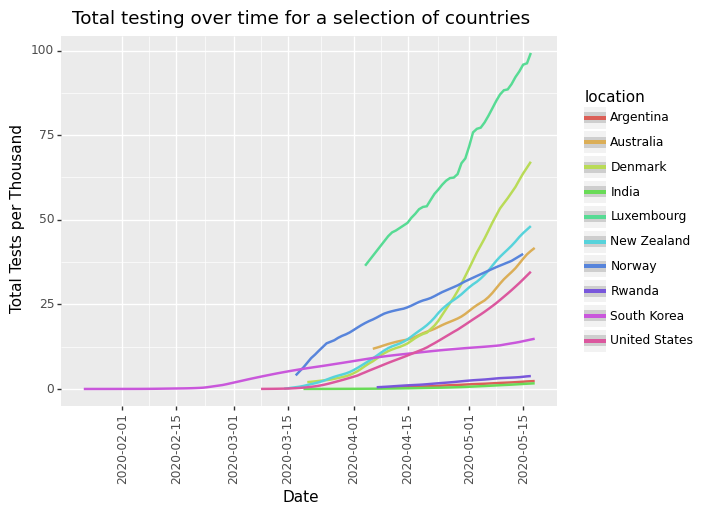

In [0]:
countries_to_analyze = ["United States", "South Korea", "Norway", "India", "Argentina", "Denmark", "Luxembourg", "Rwanda", "New Zealand", "Australia"]

(ggplot(df.loc[df["location"].isin(countries_to_analyze)])
    + aes(x="date", y="total_tests_per_thousand", color="location")
    # + geom_point()
    + geom_smooth(span=0.1)
    + xlab("Date")
    + ylab("Total Tests per Thousand")
    + ggtitle("Total testing over time for a selection of countries")
    + theme(axis_text_x=element_text(angle=90, vjust=1))
).draw();

We've used `ggplot` to make our graph, which is included in the `plotnine` Python library. `ggplot` is originally a plotting tool in R, and `plotnine` was created to help R programmers easily transition to Python. As a result, almost everything in `ggplot` for Python is nearly identical to the R version. [The plotnine documentation ](https://plotnine.readthedocs.io/en/stable/) has plenty of information on how to use the basics of `ggplot`, but if you want more advanced examples, you can look at the[ R documentation](https://ggplot2.tidyverse.org/reference/index.html). There are some differences in syntax, but it's easy to adjust to these by pattern matching against the `plotnine` documentation (for example, the R library uses dot notation for some functions which in Python use underscores, such as element.text vs element_text).

`ggplot` plots are initialized with some data. In this case, we pass in our dataframe as the data to be plotted. Specifically, we pass in the subset of rows whose "location" column is in our list of countries to plot.

Then, we can add aesthetic mappings, layers, and more to our plot. The base aesthetic mapping is for the plot, but there can be additional aesthetic mappings for each layer we add. The base aesthetic mapping can tell the plot what to plot on each axis and how to determine the color of what is plotted. Then, we add in `geom_point` or `geom_smooth` or both, which actually place points or a curve on our plot. `geom_smooth` is able to take arguments for how it determines the smoothing and how much it smooths (this is what `span` is). In this case, we didn't plot each point because the chart would look significantly more noisy with points, and the lines convey the same information.

Then, we add in guides, which allow us to label the axes and the plot. Finally, we add a theme, which allows us to style the non-data elements of the plot. In particular, we are able to rotate the date labels 90 degrees to make them not overlap with each other.

### Plot Analysis

This plot shows us that different countries ramped up their testing at different times, and currently have wildly different levels of tests per capita performed. This is enough information for us to move on to our hypothesis testing, as there is clearly enough difference between countries here.

### More Exploratory Data Analysis

Even though we could theoretically move on to our hypothesis testing now, we can do some more analysis on our data to learn more about COVID-19 deaths and how they relate to testing.


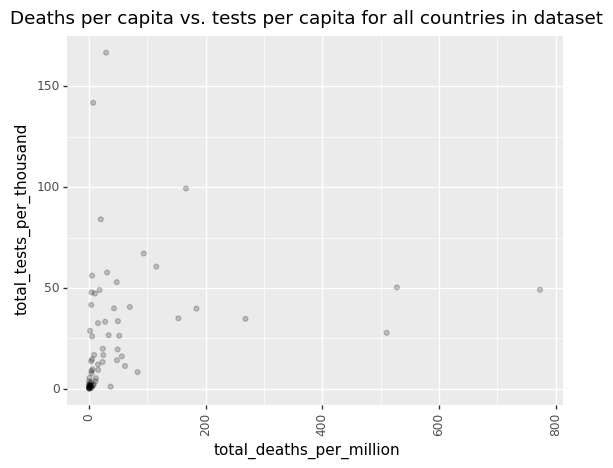

<ggplot: (8763678924741)>

In [0]:
agg_data = df.groupby("location").agg({"total_tests_per_thousand": "max", "total_deaths_per_million": "max"})
(ggplot(agg_data)
    + aes(x="total_deaths_per_million", y="total_tests_per_thousand")
    + geom_point(alpha=0.2)
    + ggtitle("Deaths per capita vs. tests per capita for all countries in dataset")
    + theme(axis_text_x=element_text(angle=90, vjust=1))
    + scale_color_discrete(guide=False))

We want to show how different countries' testing corresponds to their deaths. We don't care about time in this plot, and we only want one point per country (we want to show the latest total data for each country on our plot). We can do this by grouping and aggregating our data. Using `pandas`, there are two functions we use: `groupby` and `agg`. These functions are used in conjunction with each other to produce a condensed dataframe. Here, we group rows into countries, so  that each country is now one row, and aggregate our total tests per thousand and total deaths per million for each of those rows. We select the max in total tests and total deaths for each country, since we're looking for the most recent data, and total tests and total deaths cannot go down over time. 

Then, we simply plot our data the same way we did before. Here, we use an alpha value on each of our points since there is a lot of clustering. Making each point translucent allows us to see where there are large clumps of points.

Our plot shows that there are a lot of countries in our dataset which have both low testing and low deaths reported. This intuitively makes sense, because either they truly have low deaths due to limited exposure to COVID-19, and therefore don't need tests, or do have cases of COVID-19 but can't attribute deaths to COVID-19 due to lack of testing to determine if people died of it.

Outside of this clump, though, the trend is still interesting. It appears that there is something of an inverse relationship between tests and deaths, with some countries having very high testing and very low deaths, and other countries having little testing but more deaths. It appears that there is a floor to testing -- if there are too few tests, the death data may be unreliable, but once there is some threshold of tests (in this plot, it appears to be around 25 tests per thousand), we can see that more tests are correlated with less deaths.

Knowing this, we can use more data in our hypothesis testing to account for countries in that first clump. For example, we can add data about GDP per capita or population density and see if adding those variables allows us to get a better fitted regression that doesn't require us to simply ignore a large clump of countries.



## Hypothesis Testing

The first step in our hypothesis testing is to determine our hypotheses (the null and alternative hypotheses):

$H_0$ is that given a regression model correlating total tests per capita, population density, GDP per capita, male and female smoking rate, and time since first case with death rate, all of the individual regression coefficients will be zero.

$H_1$ is that given a regression model correlating total tests per capita, population density, GDP per capita, male and female smoking rate, and time since first case with death rate, at least one of the individual regression coefficients will be significantly different from zero.

From here, we know what data we need to test our hypothesis. The only data that we need that isn't in our raw data table is the time since first case for each country. 

In [0]:
agg_data = df.groupby("location").agg({"total_deaths_per_million": "max", "total_cases_per_million": "max"})
agg_data["first_case_date"] = pd.to_datetime("today")

for _, row in df.iterrows():
    if row["total_cases"] > 0:
        if agg_data.loc[row["location"]]["first_case_date"] > row["date"]:
            agg_data.loc[row["location"], ["first_case_date"]] = row["date"]
agg_data

,total_deaths_per_million,total_cases_per_million,first_case_date
location,,,
Argentina,8.098,172.405,2020-04-09
Australia,3.843,276.276,2020-04-06
Austria,69.839,1793.613,2020-02-26
Bahrain,7.052,4087.958,2020-03-10
Bangladesh,1.992,135.212,2020-03-09
...,...,...,...
United Kingdom,510.208,3589.768,2020-01-31
United States,268.137,4434.659,2020-03-08
Uruguay,5.758,211.300,2020-03-29


To get the data for time since first case, we need to find out when the first case date was for each country. We can then later subtract this date from the date of each data point.

We do our aggregation by country the same way we did it before, then simply iterate through each row in our original dataframe to find the minimum date with more than 0 cases for each country.


In [0]:
df = df.join(agg_data[["first_case_date"]], on="location")
df["since_case_date"] = (df["date"] - df["first_case_date"]).astype(int)
df

,iso_code,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,tests_units,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cvd_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_100k,first_case_date,since_case_date
602,ARG,Argentina,2020-04-09,1795,80,65,5,39.716,1.770,1.438,0.111,14850.0,1520.0,0.329,0.034,tests performed,45195777.0,16.177,31.9,11.198,7.441,18933.907,0.6,191.032,5.50,16.2,27.7,NaN,5.0,2020-04-09,0
603,ARG,Argentina,2020-04-10,1894,99,79,14,41.907,2.190,1.748,0.310,16379.0,1529.0,0.362,0.034,tests performed,45195777.0,16.177,31.9,11.198,7.441,18933.907,0.6,191.032,5.50,16.2,27.7,NaN,5.0,2020-04-09,86400000000000
604,ARG,Argentina,2020-04-11,1975,81,82,3,43.699,1.792,1.814,0.066,18027.0,1648.0,0.399,0.036,tests performed,45195777.0,16.177,31.9,11.198,7.441,18933.907,0.6,191.032,5.50,16.2,27.7,NaN,5.0,2020-04-09,172800000000000
607,ARG,Argentina,2020-04-14,2272,69,98,3,50.270,1.527,2.168,0.066,22805.0,3047.0,0.505,0.067,tests performed,45195777.0,16.177,31.9,11.198,7.441,18933.907,0.6,191.032,5.50,16.2,27.7,NaN,5.0,2020-04-09,432000000000000
608,ARG,Argentina,2020-04-15,2432,160,105,7,53.810,3.540,2.323,0.155,24374.0,1569.0,0.539,0.035,tests performed,45195777.0,16.177,31.9,11.198,7.441,18933.907,0.6,191.032,5.50,16.2,27.7,NaN,5.0,2020-04-09,518400000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17994,ZWE,Zimbabwe,2020-05-10,36,1,4,0,2.422,0.067,0.269,0.000,9872.0,279.0,0.664,0.019,tests performed,14862927.0,42.729,19.6,2.822,1.882,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7,2020-05-07,259200000000000
17995,ZWE,Zimbabwe,2020-05-11,36,0,4,0,2.422,0.000,0.269,0.000,10598.0,726.0,0.713,0.049,tests performed,14862927.0,42.729,19.6,2.822,1.882,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7,2020-05-07,345600000000000
17996,ZWE,Zimbabwe,2020-05-12,37,1,4,0,2.489,0.067,0.269,0.000,11058.0,460.0,0.744,0.031,tests performed,14862927.0,42.729,19.6,2.822,1.882,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7,2020-05-07,432000000000000
17997,ZWE,Zimbabwe,2020-05-13,37,0,4,0,2.489,0.000,0.269,0.000,11191.0,133.0,0.753,0.009,tests performed,14862927.0,42.729,19.6,2.822,1.882,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7,2020-05-07,518400000000000


To get our dates for each country into our original dataframe, we use `join`. The default `join` in `pandas` is a left join, which keeps everything in the "left" table and adds in things from the "right" table. In this case, the "left" table is `df` and the right table is `agg_data`. This will put the first case date into each row based on its country, since we're joining on location.

Then, we can subtract the the first case date from the date column to get a measure of how much time there has been since the first case date for each data point.


In [0]:
X = df[['total_tests_per_thousand', 'population_density', 'gdp_per_capita', 'since_case_date', 'male_smokers', 'female_smokers']]
y = df['total_deaths_per_million']
poly = PolynomialFeatures(degree=4)
poly_vars = poly.fit_transform(X)
poly_var_train, poly_var_test, y_train, y_test = train_test_split(poly_vars, y, test_size = 0.3, random_state=4)

lm = LinearRegression(normalize=True, fit_intercept=True).fit(poly_var_train, y_train)
lm.score(poly_var_test, y_test)

0.9893102516684293

We then fit our data, containing all the relevant columns, with a polynomial model using the `LinearRegression` class from `sklearn` in conjuction with `PolynomialFeatures`. This allows us to determine a polynomial curve that fits the relationship between the input and output columns. Additionally, we perform train-test split so that we can verify our results against data unused in our training operation.

The output produced above corresponds to the $R^2$ value used to score our linear regression model. This indicates that 95.57% of the variance in the total deaths per million may be explained by our selected variables, which is quite a strong relationship.

In [0]:
params = np.append(lm.intercept_, lm.coef_)
predictions = lm.predict(poly_var_test)

newX = pd.DataFrame({"Constant":np.ones(len(poly_var_test))}).join(pd.DataFrame(poly_var_test))
MSE = (sum((y_test-predictions)**2))/(len(newX)-len(newX.columns))

var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
sd_b = np.sqrt(var_b)
ts_b = params/ sd_b

p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-1))) for i in ts_b]

sd_b = np.round(sd_b,3)
ts_b = np.round(ts_b,3)
p_values = np.round(p_values,3)
params = np.round(params,4)

myDF3 = pd.DataFrame()
myDF3["Coefficients"], myDF3["Standard Errors"], myDF3["t statistics"], myDF3["p-values"] = [params,sd_b,ts_b,p_values]
myDF3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in sqrt
  


,Coefficients,Standard Errors,t statistics,p-values
0,3.587018e+10,NaN,NaN,NaN
1,-3.000000e-04,1.854319e+10,-0.000000e+00,1.0
2,1.082425e+02,2.995400e+01,3.614000e+00,0.0
3,-3.350518e+08,6.763000e+00,-4.954035e+07,0.0
4,-6.812252e+06,4.500000e-02,-1.528722e+08,0.0
...,...,...,...,...
206,2.929992e+04,1.000000e-03,5.183677e+07,0.0
207,-7.347636e+04,3.000000e-03,-2.807108e+07,0.0
208,3.478106e+05,NaN,NaN,NaN
209,-2.449073e+05,4.000000e-03,-6.974031e+07,0.0


As may be observed above, there are a number of p-values significantly below 0.05, indicating that there are coefficients significantly different than 0. Thus, we may reject $H_0$ in favor of $H_1$.

Let us now use our model to make a prediction about how the United States would be faring in terms of deaths per million if we had a 50% increase in testing capacity:

In [0]:
row = df.loc[df['location'] == 'United States'].iloc[-1]
x = np.hstack((1.5 * df.loc[df['location'] == 'United States'].iloc[-1]['total_tests_per_thousand'], row[['population_density', 'gdp_per_capita', 'since_case_date', 'male_smokers', 'female_smokers']]))[None]
deaths = lm.predict(poly.fit_transform(x))
deaths[0]

117.91931915283203

In [0]:
row["total_deaths_per_million"]

268.137

We can see that this is less than half the number of deaths  that we currently have. We can also look at how many deaths we would have if we had half the testing that we currently have:

In [0]:
x = np.hstack((0.5 * df.loc[df['location'] == 'United States'].iloc[-1]['total_tests_per_thousand'], row[['population_density', 'gdp_per_capita', 'since_case_date', 'male_smokers', 'female_smokers']]))[None]
deaths = lm.predict(poly.fit_transform(x))
deaths[0]

344.7753372192383